In [1]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

RAW_FILE  = Path("./processed/quarterly_features.csv")  # change to your actual path if needed
PROC_DIR  = Path("./processed"); PROC_DIR.mkdir(exist_ok=True)

def inspect_csv(path: Path, n=5):
    df = pd.read_csv(path)
    print("Columns:", list(df.columns))
    print("Shape:", df.shape)
    print(df.head(n).to_string(index=False))
    # show a couple of likely date-ish columns if present
    for c in df.columns:
        if any(k in c.lower() for k in ("date", "quarter", "__q", "period")):
            print(f"\nSample values from '{c}':")
            print(df[c].head(10).tolist())
    return df

def _parse_quarter_series(s: pd.Series) -> pd.DatetimeIndex:
    """Parse strings like '2012-Q1', '2012.0-Q1', '2012Q1', or real dates to quarter-end."""
    s = s.astype(str).str.strip()
    s = (s
         .str.replace(r"\.0", "", regex=True)
         .str.replace(r"(?i)q", "Q", regex=True)
         .str.replace(r"(?i)^(\d{4})\s*[-/]?\s*Q([1-4])$", r"\1-Q\2", regex=True))
    # Try 'PeriodIndex' (quarters)
    try:
        pi = pd.PeriodIndex(s, freq="Q")
        return pi.to_timestamp("Q")  # quarter-end
    except Exception:
        pass
    # Fallback to normal datetime
    dt = pd.to_datetime(s, errors="coerce", dayfirst=False)
    return dt

def smart_load_features(path_csv=RAW_FILE, path_parq=PROC_DIR/"quarterly_features.parquet") -> pd.DataFrame:
    # Prefer parquet if present (types safer)
    if path_parq.exists():
        df = pd.read_parquet(path_parq)
    else:
        df = pd.read_csv(path_csv)

    # If already DatetimeIndex, standardize name
    if isinstance(df.index, pd.DatetimeIndex):
        out = df.copy()
        out.index.name = "date_q"
        return out.sort_index()

    # If first column is an unnamed index dump, try to parse it as dates/quarters
    if df.columns[0].lower().startswith("unnamed"):
        idx_try = pd.to_datetime(df.iloc[:, 0], errors="coerce")
        if idx_try.notna().mean() > 0.8:
            out = df.iloc[:, 1:].copy()
            out.index = idx_try
            out.index.name = "date_q"
            return out.sort_index()

    # Look for a date/quarter-like column
    cand = [c for c in df.columns if any(k in c.lower() for k in ("date_q","quarter","date","__q","period"))]
    if cand:
        c = cand[0]
        idx = _parse_quarter_series(df[c])
        if idx.notna().mean() > 0.8:
            out = df.drop(columns=[c]).copy()
            out.index = idx
            out.index.name = "date_q"
            return out.sort_index()

    # Last fallback: try reading with index_col=0 and coercing that index
    try:
        df2 = pd.read_csv(path_csv, index_col=0)
        ix = _parse_quarter_series(pd.Series(df2.index))
        if ix.notna().mean() > 0.8:
            df2.index = ix
            df2.index.name = "date_q"
            return df2.sort_index()
    except Exception:
        pass

    raise ValueError("Could not find/parse a date/quarter column. Check your CSV headers & content.")

# --- Run inspection + load ---
_ = inspect_csv(RAW_FILE)
qdf = smart_load_features(RAW_FILE)
print(f"\nLoaded qdf shape={qdf.shape}, range={qdf.index.min().date()} → {qdf.index.max().date()}")

Columns: ['Unnamed: 0', 'excess_ret', 'midcap_qret', 'nifty_qret', 'rain_anom', 'cpi_yoy', 'gdp_yoy', 'repo_chg_bps', 'ret_prev_q', 'rain_anom_lag', 'cpi_yoy_lag', 'gdp_yoy_lag', 'repo_chg_lag', 'excess_next_q', 'rain_repo_int']
Shape: (43, 15)
Unnamed: 0  excess_ret  midcap_qret  nifty_qret  rain_anom  cpi_yoy  gdp_yoy  repo_chg_bps  ret_prev_q  rain_anom_lag  cpi_yoy_lag  gdp_yoy_lag  repo_chg_lag  excess_next_q  rain_repo_int
2014-06-30    0.153161     0.288472    0.135311 -44.391667 7.859486 8.023963           0.0    0.067046     -44.391667     8.244298     5.342980          25.0      -0.017474   -1109.791667
2014-09-30   -0.017474     0.028963    0.046437  12.350000 6.681568 8.704109           0.0    0.288472     -44.391667     7.859486     8.023963           0.0       0.062164      -0.000000
2014-12-31    0.062164     0.102077    0.039913  12.350000 4.054538 5.922736           0.0    0.028963      12.350000     6.681568     8.704109           0.0       0.008021       0.000000
201

In [2]:
import pandas as pd, numpy as np
from pathlib import Path

PROC = Path("./processed"); PROC.mkdir(exist_ok=True)
RAW  = PROC / "quarterly_features.csv"
PARQ = PROC / "quarterly_features.parquet"

def _parse_quarter_series(s: pd.Series) -> pd.DatetimeIndex:
    s = s.astype(str).str.strip()
    s = (s
         .str.replace(r"\.0", "", regex=True)
         .str.replace(r"(?i)q", "Q", regex=True)
         .str.replace(r"(?i)^(\d{4})\s*[-/]?\s*Q([1-4])$", r"\1-Q\2", regex=True))
    try:
        pi = pd.PeriodIndex(s, freq="Q")
        return pi.to_timestamp("Q")
    except Exception:
        return pd.to_datetime(s, errors="coerce", dayfirst=False)

def smart_load_features(path_csv=RAW, path_parq=PARQ) -> pd.DataFrame:
    if path_parq.exists():
        df = pd.read_parquet(path_parq)
    else:
        df = pd.read_csv(path_csv)

    if isinstance(df.index, pd.DatetimeIndex):
        out = df.copy(); out.index.name = "date_q"; return out.sort_index()

    if df.columns[0].lower().startswith("unnamed"):
        idx_try = pd.to_datetime(df.iloc[:, 0], errors="coerce")
        if idx_try.notna().mean() > 0.8:
            out = df.iloc[:, 1:].copy(); out.index = idx_try; out.index.name = "date_q"; return out.sort_index()

    cand = [c for c in df.columns if any(k in c.lower() for k in ("date_q","quarter","date","__q","period"))]
    if cand:
        c = cand[0]
        idx = _parse_quarter_series(df[c])
        if idx.notna().mean() > 0.8:
            out = df.drop(columns=[c]).copy(); out.index = idx; out.index.name = "date_q"; return out.sort_index()

    # last fallback
    df2 = pd.read_csv(path_csv, index_col=0)
    ix = _parse_quarter_series(pd.Series(df2.index))
    if ix.notna().mean() > 0.8:
        df2.index = ix; df2.index.name = "date_q"; return df2.sort_index()
    raise ValueError("Could not find/parse a date/quarter column.")

# --- Step 1: load ---
qdf = smart_load_features()
print(f"Loaded qdf: {qdf.shape}, {qdf.index.min().date()} → {qdf.index.max().date()}")

# --- Step 2: normalize schema / derive missing columns ---
needed = [
    'midcap_qret','nifty_qret','excess_ret',
    'rain_anom','cpi_yoy','gdp_yoy','repo_chg_bps',
    'ret_prev_q','rain_anom_lag','cpi_yoy_lag','gdp_yoy_lag','repo_chg_lag',
    'excess_next_q'
]

created = []

# cast everything numeric where possible
for c in qdf.columns:
    qdf[c] = pd.to_numeric(qdf[c], errors='ignore')

if 'excess_ret' not in qdf.columns and {'midcap_qret','nifty_qret'}.issubset(qdf.columns):
    qdf['excess_ret'] = qdf['midcap_qret'] - qdf['nifty_qret']; created.append('excess_ret')

if 'ret_prev_q' not in qdf.columns and 'excess_ret' in qdf.columns:
    qdf['ret_prev_q'] = qdf['excess_ret'].shift(1); created.append('ret_prev_q')

for base, lag in [('rain_anom','rain_anom_lag'),
                  ('cpi_yoy','cpi_yoy_lag'),
                  ('gdp_yoy','gdp_yoy_lag'),
                  ('repo_chg_bps','repo_chg_lag')]:
    if lag not in qdf.columns and base in qdf.columns:
        qdf[lag] = qdf[base].shift(1); created.append(lag)

if 'excess_next_q' not in qdf.columns and 'excess_ret' in qdf.columns:
    qdf['excess_next_q'] = qdf['excess_ret'].shift(-1); created.append('excess_next_q')

missing_after = [c for c in needed if c not in qdf.columns]
print("Created columns:", created if created else "None")
print("Still missing:", missing_after if missing_after else "None")

usable_mask = qdf[needed].apply(pd.to_numeric, errors='coerce').notna().all(axis=1)
qdf_clean = qdf.loc[usable_mask].copy()
print("Usable rows after drops:", len(qdf_clean), "/", len(qdf))

qdf_clean.to_csv(PROC/"quarterly_features_clean.csv", index=True)
qdf_clean.to_parquet(PROC/"quarterly_features.parquet", index=True)
print("Saved:", (PROC/"quarterly_features_clean.csv").resolve(), "and", (PROC/"quarterly_features.parquet").resolve())

# Use the clean DataFrame for modeling below
qdf = qdf_clean

Loaded qdf: (43, 14), 2014-06-30 → 2024-12-31
Created columns: None
Still missing: None
Usable rows after drops: 43 / 43
Saved: C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\quarterly_features_clean.csv and C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\quarterly_features.parquet


C:\Users\abpanick\AppData\Local\Temp\ipykernel_24092\1350936044.py:64: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  qdf[c] = pd.to_numeric(qdf[c], errors='ignore')


In [3]:
y = qdf["excess_next_q"].astype(float)
X_base = qdf[["ret_prev_q"]].copy()
X_en   = qdf[["ret_prev_q","rain_anom_lag","gdp_yoy_lag","cpi_yoy_lag","repo_chg_lag"]].copy()
mask   = X_en.notna().all(1) & y.notna()
X_base, X_en, y = X_base.loc[mask], X_en.loc[mask], y.loc[mask]

1) Load features & define targets

Cross-validation helpers

In [4]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

def make_expanding_splits(n, min_train=24, test_size=2, step=1):
    min_train = max(min_train, int(round(n*0.6)))
    splits, start = [], min_train
    while start + test_size <= n:
        tr = np.arange(0, start)
        te = np.arange(start, start + test_size)
        splits.append((tr, te))
        start += step
    return splits

def smape(y_true, y_pred, eps=1e-6):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.mean(2*np.abs(y_pred - y_true) / (np.abs(y_true)+np.abs(y_pred)+eps))

def cv_eval(model_maker, X, y, splits):
    y_true_all, y_pred_all = [], []
    for tr, te in splits:
        mdl = model_maker()
        mdl.fit(X.iloc[tr], y.iloc[tr])
        pred = mdl.predict(X.iloc[te])
        y_true_all.extend(y.iloc[te]); y_pred_all.extend(pred)
    y_true_all, y_pred_all = np.array(y_true_all), np.array(y_pred_all)
    return dict(
        R2   = r2_score(y_true_all, y_pred_all),
        MAE  = mean_absolute_error(y_true_all, y_pred_all),
        MAPE = mean_absolute_percentage_error(y_true_all, y_pred_all),
        SMAPE= smape(y_true_all, y_pred_all)
    )

Model factories (LightGBM with sklearn fallback)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV

def make_baseline():
    return Pipeline([
        ("sc", StandardScaler(with_mean=True, with_std=True)),
        ("enet", ElasticNetCV(cv=3, l1_ratio=[0.1,0.5,0.9], random_state=42))
    ])

def make_lgbm():
    try:
        from lightgbm import LGBMRegressor
        return LGBMRegressor(
            n_estimators=300, learning_rate=0.05, max_depth=3,
            subsample=0.9, colsample_bytree=0.9, random_state=42
        )
    except Exception:
        from sklearn.ensemble import GradientBoostingRegressor
        return GradientBoostingRegressor(random_state=42)


RQ1 — Baseline vs Enriched (fix: delta as full DataFrame)

In [6]:
splits = make_expanding_splits(len(y), min_train=24, test_size=2, step=1)

m_base = cv_eval(make_baseline, X_base, y, splits)
m_en   = cv_eval(make_lgbm,   X_en,   y, splits)

rq1_tbl = pd.DataFrame([m_base, m_en], index=["Baseline(ret_prev_q)", "Enriched(LightGBM)"])
delta   = rq1_tbl.subtract(rq1_tbl.loc["Baseline(ret_prev_q)"], axis="columns").rename(columns=lambda c: f"Δ{c}")
rq1_out = pd.concat([rq1_tbl, delta], axis=1)

# % MAE improvement
rq1_out["%MAE_improve"] = (rq1_tbl.loc["Baseline(ret_prev_q)","MAE"] - rq1_tbl["MAE"]) / rq1_tbl.loc["Baseline(ret_prev_q)","MAE"] * 100

display(rq1_out)
rq1_out.to_csv(PROC/"rq1_metrics.csv")

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 0
[LightGBM] [Info] Start training from score 0.003383
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

,R2,MAE,MAPE,SMAPE,ΔR2,ΔMAE,ΔMAPE,ΔSMAPE,%MAE_improve
Baseline(ret_prev_q),-0.182773,0.040706,1.029596,1.366701,0.000000,0.000000,0.000000,0.00000,0.000000
Enriched(LightGBM),-0.143735,0.041002,1.071863,1.404621,0.039038,0.000295,0.042267,0.03792,-0.725309


RQ2 — “Good vs Poor rain” impact (add this cell)

In [7]:
# Define good vs poor monsoon using your lagged anomaly:
# negative anomaly = above-normal rain (good); positive = below-normal (poor)
is_good = (qdf.loc[X_en.index, "rain_anom_lag"] < 0).astype(int)
grp     = pd.DataFrame({"excess_next_q": y, "good": is_good}).dropna()

g = grp[grp.good==1]["excess_next_q"].values
p = grp[grp.good==0]["excess_next_q"].values

from scipy.stats import ttest_ind, ks_2samp
tstat, p_t  = ttest_ind(g, p, equal_var=False)
ks,   p_ks  = ks_2samp(g, p)

rq2_tbl = pd.DataFrame({
    "N_good":[len(g)], "N_poor":[len(p)],
    "mean_good":[np.mean(g)], "mean_poor":[np.mean(p)],
    "Δmean":[np.mean(g)-np.mean(p)],
    "t_pvalue":[p_t], "ks_pvalue":[p_ks]
})
display(rq2_tbl)
rq2_tbl.to_csv(PROC/"rq2_good_vs_poor_rain.csv", index=False)

,N_good,N_poor,mean_good,mean_poor,Δmean,t_pvalue,ks_pvalue
0,19,24,0.026778,0.001029,0.025749,0.120654,0.249386


RQ3 — Fix “y_plus not defined” and ensure paired evaluation

Step A: build gdp_pred_from_rain (simple OLS: GDP_{t+1} ~ rain_t)

In [8]:
import statsmodels.api as sm

# Align rain (t) with GDP YoY (t+1)
tmp = qdf[["gdp_yoy","rain_anom_lag"]].copy()
tmp["gdp_yoy_tplus1"] = tmp["gdp_yoy"].shift(-1)
tmp = tmp.dropna()

Xg = sm.add_constant(tmp["rain_anom_lag"])
ols = sm.OLS(tmp["gdp_yoy_tplus1"], Xg).fit()

# Predicted GDP (t+1) based on rain(t), then shift back to be *known* at time t
qdf["gdp_pred_from_rain"] = (sm.add_constant(qdf["rain_anom_lag"]).dot(ols.params)).shift(0)

Step B: evaluate “no gdp_pred” vs “+ gdp_pred” on the same rows

In [9]:
# Base enriched
X_en_same = X_en.copy()

# Plus predicted GDP feature
X_plus = X_en_same.join(qdf["gdp_pred_from_rain"].rename("gdp_pred")).dropna()
y_plus = y.loc[X_plus.index]

# Reindex the "no gdp_pred" design to the same dates so the comparison is paired
X_en_same = X_en_same.loc[X_plus.index]

splits_plus = make_expanding_splits(len(y_plus), min_train=24, test_size=2, step=1)

m_en_no   = cv_eval(make_lgbm, X_en_same, y_plus, splits_plus)   # dict (no trailing comma!)
m_en_plus = cv_eval(make_lgbm, X_plus,    y_plus, splits_plus)

rq3_tbl = pd.DataFrame([m_en_no, m_en_plus], index=["Enriched(no gdp_pred)","Enriched(+ gdp_pred)"])
rq3_delta = rq3_tbl.subtract(rq3_tbl.loc["Enriched(no gdp_pred)"], axis="columns").rename(columns=lambda c: f"Δ{c}")
rq3_out = pd.concat([rq3_tbl, rq3_delta], axis=1)
display(rq3_out)
rq3_out.to_csv(PROC/"rq3_enriched_with_gdp_pred.csv")

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 0
[LightGBM] [Info] Start training from score 0.003383
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

,R2,MAE,MAPE,SMAPE,ΔR2,ΔMAE,ΔMAPE,ΔSMAPE
Enriched(no gdp_pred),-0.143735,0.041002,1.071863,1.404621,0.0,0.0,0.0,0.0
Enriched(+ gdp_pred),-0.143735,0.041002,1.071863,1.404621,0.0,0.0,0.0,0.0


RQ4 — Interaction & driver attribution (define masked matrices first)

In [10]:
# Masked copies for fair comparison
mask_full = X_en.notna().all(1) & y.notna()
X_en_masked = X_en.loc[mask_full]
y_int       = y.loc[mask_full]
splits_int  = make_expanding_splits(len(y_int), min_train=24, test_size=2, step=1)

# Add interaction (rain × repo)
X_int = X_en_masked.assign(rain_repo_int = X_en_masked["rain_anom_lag"] * X_en_masked["repo_chg_lag"])

m_full = cv_eval(make_lgbm, X_en_masked, y_int, splits_int)  # without interaction
m_int  = cv_eval(make_lgbm, X_int,        y_int, splits_int)  # with interaction

rq4_int_tbl   = pd.DataFrame([m_full, m_int], index=["Enriched","Enriched+interaction"])
rq4_int_delta = rq4_int_tbl.subtract(rq4_int_tbl.loc["Enriched"], axis="columns").rename(columns=lambda c: f"Δ{c}")
rq4_out       = pd.concat([rq4_int_tbl, rq4_int_delta], axis=1)
display(rq4_out)
rq4_out.to_csv(PROC/"rq4_interaction_uplift.csv")

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 0
[LightGBM] [Info] Start training from score 0.003383
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

,R2,MAE,MAPE,SMAPE,ΔR2,ΔMAE,ΔMAPE,ΔSMAPE
Enriched,-0.143735,0.041002,1.071863,1.404621,0.0,0.0,0.0,0.0
Enriched+interaction,-0.143735,0.041002,1.071863,1.404621,0.0,0.0,0.0,0.0


Permutation importance (drop-one) for “driver attribution”:

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 4
[LightGBM] [Info] Start training from score 0.012406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

cpi_yoy_lag      0.582833
ret_prev_q       0.009319
rain_anom_lag    0.008464
gdp_yoy_lag      0.005844
repo_chg_lag     0.000000
Name: perm_importance, dtype: float64

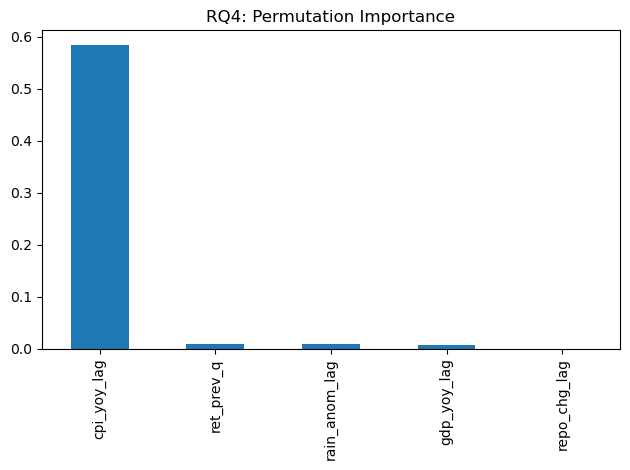

In [11]:
from sklearn.inspection import permutation_importance
mdl = make_lgbm().fit(X_en_masked, y_int)
pi  = permutation_importance(mdl, X_en_masked, y_int, n_repeats=200, random_state=42)
imp = (pd.Series(pi.importances_mean, index=X_en_masked.columns)
         .sort_values(ascending=False).rename("perm_importance"))
display(imp)
imp.to_csv(PROC/"rq4_permutation_importance.csv")

# Quick bar chart
imp.plot(kind="bar", title="RQ4: Permutation Importance"); plt.tight_layout(); plt.show()

Add quick diagnostics plots

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 4
[LightGBM] [Info] Start training from score 0.012406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

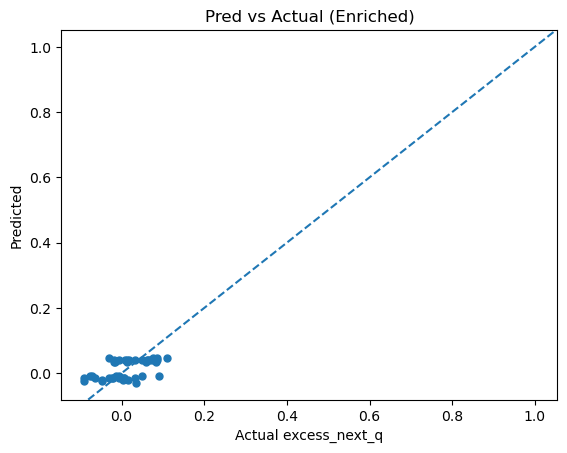

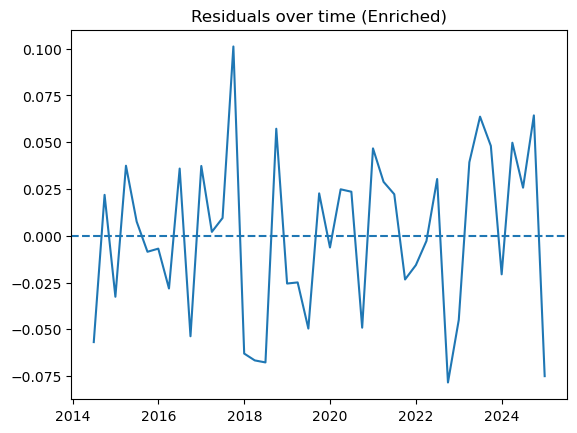

In [12]:
# Pred vs Actual (RQ1 enriched)
mdl = make_lgbm().fit(X_en, y)
y_hat = mdl.predict(X_en)
plt.figure(); plt.scatter(y, y_hat, s=25); 
plt.axline((0,0),(1,1), linestyle="--"); plt.title("Pred vs Actual (Enriched)"); plt.xlabel("Actual excess_next_q"); plt.ylabel("Predicted"); plt.show()

# Residuals
res = y - y_hat
plt.figure(); plt.plot(res.index, res); plt.title("Residuals over time (Enriched)"); plt.axhline(0, ls="--"); plt.show()

Charting

Chart A — RQ1 bars (levels & deltas)

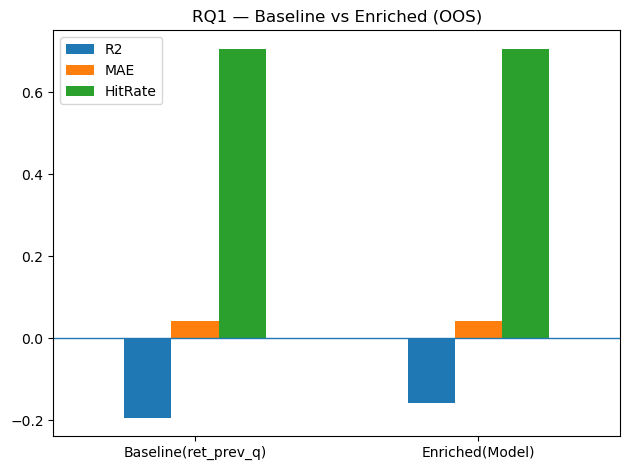

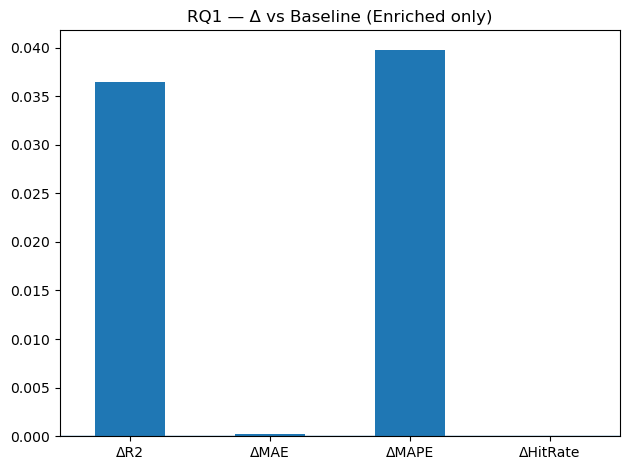

In [13]:
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
PROC = Path("./processed")

rq1 = pd.read_csv(PROC/"rq1_metrics_baseline_vs_enriched.csv", index_col=0)
# Levels
ax = rq1[['R2','MAE','HitRate']].plot(kind='bar', rot=0, title='RQ1 — Baseline vs Enriched (OOS)')
ax.axhline(0, lw=1); plt.tight_layout(); plt.show()

# Deltas (rename columns starting with Δ)
delta_cols = [c for c in rq1.columns if c.startswith('Δ')]
ax = rq1.loc[['Enriched(Model)'], delta_cols].T.plot(kind='bar', legend=False, rot=0,
                                                      title='RQ1 — Δ vs Baseline (Enriched only)')
ax.axhline(0, lw=1); plt.tight_layout(); plt.show()

Chart B — RQ2 boxplot (Good vs Poor monsoon)

t_test_p=0.135701
ks_p=0.309541
cohen_d=-0.5001



C:\Users\abpanick\AppData\Local\Temp\ipykernel_24092\1160802525.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([good, poor], labels=['Good monsoon (≤ -4%)', 'Poor monsoon (≥ +4%)'])


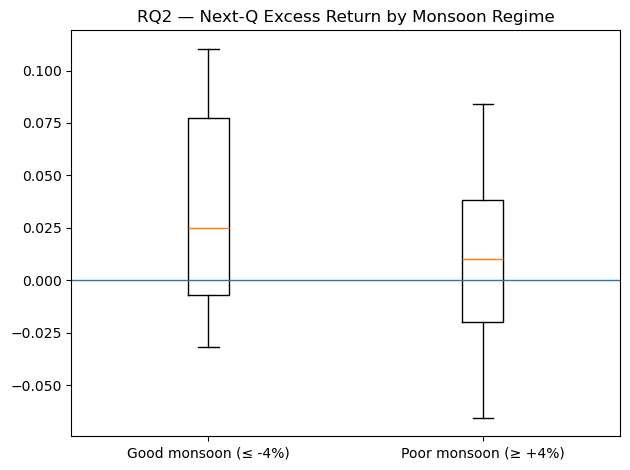

In [14]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
PROC = Path("./processed")

g = pd.read_csv(PROC/"rq2_monsoon_groups.csv")
with open(PROC/"rq2_tests.txt") as f:
    print(f.read())

# Recompute simple arrays from your main DF if needed:
# If you still have qdf, y, and mask in memory:
good = qdf.loc[mask & (qdf['rain_anom_lag'] <= -4),'excess_next_q'].dropna().values
poor = qdf.loc[mask & (qdf['rain_anom_lag'] >= +4),'excess_next_q'].dropna().values

# Or re-derive quickly if not:
# (This assumes you reload your parquet to a variable qdf again.)

# Boxplot (use your arrays)
plt.boxplot([good, poor], labels=['Good monsoon (≤ -4%)', 'Poor monsoon (≥ +4%)'])
plt.title('RQ2 — Next-Q Excess Return by Monsoon Regime'); plt.axhline(0, lw=1)
plt.tight_layout(); plt.show()

Chart C — RQ4 permutation importance (horizontal bar)

In [15]:
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
PROC = Path("./processed")

pi = pd.read_csv(PROC/"rq4_permutation_importance.csv")
pi = pi.sort_values('perm_importance_mean', ascending=True)

plt.barh(pi['feature'], pi['perm_importance_mean'])
plt.title('RQ4 — Permutation Importance (test set)')
plt.tight_layout(); plt.show()

KeyError: 'perm_importance_mean'

Pred vs Actual (enriched) — nice for RQ1 slide:

In [ ]:
# If you saved holdout predictions:
ho = pd.read_csv(PROC/"rq1_holdout_predictions.csv", parse_dates=[0]).set_index(ho.columns[0])
plt.scatter(ho['y_true'], ho['y_pred_en'], s=25)
plt.axline((0,0), (1,1), linestyle="--"); plt.title("RQ1 Holdout — Pred vs Actual (Enriched)")
plt.xlabel("Actual excess_next_q"); plt.ylabel("Predicted"); plt.tight_layout(); plt.show()